## Load packages

In [1]:
import numpy as np
import pandas as pd
import math
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D
from keras.layers import AveragePooling1D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix

%matplotlib inline

Using TensorFlow backend.
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/magu/.local/lib/python3.6/site-packages/tensorflow/python/framewo

In [2]:
# set number of cores to 8
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=8, 
                                                   inter_op_parallelism_threads=8)))

## Load dataset

In [3]:
# import Matt's 'chr1_ukb_X.npz' file
chr1_ukb_X = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')
# create dict mapping from sampleid to superpopulation
sampleid_to_superpopulation_pandas_df = pd.read_csv('/home/jsokol/Data/igsr_samples.tsv', delimiter="\t")
sampleid_to_superpopulation_dict = sampleid_to_superpopulation_pandas_df.set_index('Sample name')['Superpopulation code'].to_dict()
# remove samples from chr1_ukb_X that are not in dict or that do no contain value
temp = set()
for x in np.nditer(chr1_ukb_X['S']):
    sample_id = str((x.item(0))).replace("'", "").replace("b", "").split("_")[0]
    if sample_id not in sampleid_to_superpopulation_dict:
        print(sample_id + ' is not in dict. Make sure to remove this sample from the dataset.')
    elif sampleid_to_superpopulation_dict[sample_id] == float('nan'):
        print(sample_id + ' maps to nan in dict')
chr1_ukb_X_G = chr1_ukb_X['G'][:,:,:]
chr1_ukb_X_V = chr1_ukb_X['V'][:,:]

In [4]:
# define number of classes
classes = [0, 1, 2, 3, 4]
# flatten input data
X_all_data = chr1_ukb_X_G.reshape(chr1_ukb_X_G.shape[0], -1).T

In [5]:
# one hot encode labels
Y_all_data = np.zeros((5, 5008))
keep=set(range(5008))
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    if sampleid_to_superpopulation_dict[sample_id] == 'AFR':
        Y_all_data[0,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'AMR':
        Y_all_data[4,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'EAS':
        Y_all_data[1,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'EUR':
        Y_all_data[2,i] = 1
    elif sampleid_to_superpopulation_dict[sample_id] == 'SAS':
        Y_all_data[3,i] = 1
    else:
        keep.remove(i)
X_all_data=X_all_data[:,np.array(list(keep))]
        

In [6]:
# randomly shuffle the order of the data
randomize = np.arange(X_all_data.shape[1])
np.random.shuffle(randomize)
X_all_data = X_all_data[:,randomize]
Y_all_data = Y_all_data[:,randomize]

In [7]:
# split data into training and test sets
ntrain=3000
X_train = X_all_data[:,:ntrain]
X_test = X_all_data[:,ntrain:]
Y_train = Y_all_data[:,:ntrain]
Y_test = Y_all_data[:,ntrain:]
# convert to correct format for use in keras
X_train = X_train[:,:,np.newaxis]
X_train = np.transpose(X_train, (1, 0, 2))
X_test = X_test[:,:,np.newaxis]
X_test = np.transpose(X_test, (1, 0, 2))
Y_train = np.transpose(Y_train, (1, 0))
Y_test = np.transpose(Y_test, (1, 0))

In [8]:
print(X_train.shape, Y_train.shape)

(3000, 231504, 1) (3000, 5)


## Build model

In [9]:
def model2(n_snps_per_sample):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=(n_snps_per_sample, 1))

    # First convolutional block
    X = Conv1D(filters=49, kernel_size=500 ,strides=500, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Second convolutional block
    X = Conv1D(49, 75, strides = 5, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling1D(2, name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(5, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model2')
    
    return model

## Create and compile the model 

In [10]:
# create model
model = model2(X_train.shape[1])
# compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 231504, 1)         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 463, 49)           24549     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 463, 49)           196       
_________________________________________________________________
activation_1 (Activation)    (None, 463, 49)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 93, 49)            180124    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 93, 49)            196       
_________________________________________________________________
activation_2 (Activation)    (None, 93, 49)            0         
__________

## Train model

In [11]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 6, batch_size = 128)

Train on 3000 samples, validate on 2008 samples
Epoch 1/6
3000/3000 [==============================] - 17s 6ms/step - loss: 4.4805 - acc: 0.5563 - val_loss: 3.4129 - val_acc: 0.7500
Epoch 2/6
3000/3000 [==============================] - 16s 5ms/step - loss: 3.3389 - acc: 0.7723 - val_loss: 3.3763 - val_acc: 0.7689
Epoch 3/6
3000/3000 [==============================] - 16s 5ms/step - loss: 3.2954 - acc: 0.7920 - val_loss: 3.3606 - val_acc: 0.7704
Epoch 4/6
3000/3000 [==============================] - 17s 6ms/step - loss: 3.2775 - acc: 0.7967 - val_loss: 3.3542 - val_acc: 0.7749
Epoch 5/6
3000/3000 [==============================] - 17s 6ms/step - loss: 3.2689 - acc: 0.7980 - val_loss: 3.3521 - val_acc: 0.7709
Epoch 6/6
3000/3000 [==============================] - 17s 6ms/step - loss: 3.2627 - acc: 0.7983 - val_loss: 3.3459 - val_acc: 0.7759


## Evaluate model

Text(0.5, 1.0, 'Loss')

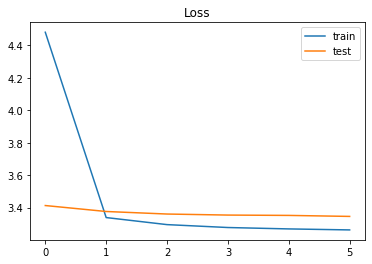

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Loss')

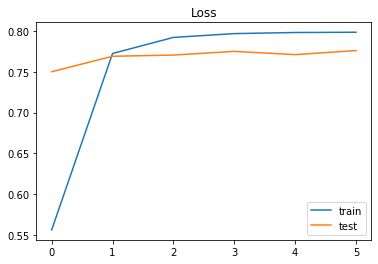

In [13]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.title('Loss')

In [14]:
print('\n# Evaluate on test data')
results = model.evaluate(X_test, Y_test, batch_size=1)
print('test loss, test acc:', results)


# Evaluate on test data
2008/2008 [==============================] - 7s 3ms/step
test loss, test acc: [3.3459356837234595, 0.7758964143426295]


In [15]:
test_Y_hat=model.predict(X_test)
print(multilabel_confusion_matrix(np.argmax(test_Y_hat, axis=-1).flatten(), 
                                  np.argmax(Y_test, axis=-1).flatten()))

[[[1501    9]
  [   3  495]]

 [[1603  405]
  [   0    0]]

 [[1541    1]
  [  35  431]]

 [[1336    0]
  [ 285  387]]

 [[1601   35]
  [ 127  245]]]


In [16]:
# weird finding: this seems to work _very_ well if we include AMR
# but not at all if we don't